# Surface concentrations

In [40]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import netCDF4 as nc
from itertools import compress
import datetime as dt
from datetime import date

%matplotlib notebook

###### Parameters:

In [3]:
imin, imax = 1480, 2180
jmin, jmax = 160, 800
isize = imax - imin
jsize = jmax - jmin

# model results:
year  = 2015
results_folder = '/data/brogalla/run_storage/Mn-set4-202004/ref-'+str(year)+'/'

###### Load files:

In [4]:
mask      = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12_Ariane_mesh.nc')
tmask     = np.array(mask.variables['tmask'])[0,:,imin:imax,jmin:jmax]
land_mask = np.ma.masked_where((tmask[:,:,:] > 0.1), tmask[:,:,:]) 

In [5]:
ref   = nc.Dataset(results_folder+'ANHA12_EXH006_'+str(year)+'_monthly.nc',  'r')
lons  = np.array(ref.variables['nav_lon'])
lats  = np.array(ref.variables['nav_lat'])
depth = np.array(ref.variables['deptht'])

In [6]:
results  = nc.Dataset(results_folder+'ANHA12_EXH006_'+str(year)+'_monthly.nc')
dissolmn = np.array(results.variables['dissolmn'][:,0,:,:,:])*10**9 # nM units

In [7]:
mask      = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12_Ariane_mesh.nc')
tmask     = np.array(mask.variables['tmask'])[0,:,imin:imax,jmin:jmax]
land_mask = np.ma.masked_where((tmask[:,:,:] > 0.1), tmask[:,:,:]) 

e1t_base = np.array(mask.variables['e1t'])[0,imin:imax,jmin:jmax]
e2t_base = np.array(mask.variables['e2t'])[0,imin:imax,jmin:jmax]
e3t      = np.array(mask.variables['e3t_0'])[0,:,imin:imax,jmin:jmax]

e1t      = np.tile(e1t_base, (50,1,1))
e2t      = np.tile(e2t_base, (50,1,1))
volume   = e1t*e2t*e3t

##### Functions:

In [51]:
def plot_layer(month, layer, variable, vmin=0,vmax=35, savefig=False):
    
    fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/mn-reference.pickle','rb'))

    x, y = proj1(lons, lats)

    contour = proj1.contourf(x, y, variable[month,layer,:,:], np.arange(vmin,vmax+1,2.5),\
                             cmap=cmocean.cm.dense, vmin=vmin, vmax=vmax, extend='both')

    cbar_ax = fig.add_axes([0.73, 0.16, 0.05, 0.6])
    cbar    = fig.colorbar(contour, cax=cbar_ax)
    cbar.set_label('Dissolved Mn [nM]', fontsize=13) 
    cbar_ax.tick_params(axis='both', which='major', labelsize=13)
    
    if savefig:
        fig.savefig('/ocean/brogalla/GEOTRACES/figures/R3-surface-field-'+\
                    str(date.today().strftime('%Y%m%d'))+'.png', bbox_inches='tight', dpi=300)
    
    return

In [33]:
def load_results(folder_ref):
    
    months  = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
    dmn_riv = np.empty((12,1,isize,jsize))   ; dmn_sed = np.empty((12,1,isize,jsize)); 
    dmn_atm = np.empty((12,1,isize,jsize))   ; dmn_ice = np.empty((12,1,isize,jsize));
    dmn_sedice = np.empty((12,1,isize,jsize));
    dmn_red = np.empty((12,50,isize,jsize)); dmn_oxi = np.empty((12,50,isize,jsize))
    
    i=0
    for month in months:
        file        = 'ANHA12_EXH006_1m_'+str(year)+'0101_'+str(year)+'1231_comp_'+str(year)+month+'-'+str(year)+month+'.nc'
        ref_monthly = nc.Dataset(folder_ref+file)
        
        dmn_riv[i,0,:,:]    = np.array(ref_monthly.variables['dmnriv'])[0,:,:]*(10**9)*(3600*24*31)
        dmn_sed[i,0,:,:]    = np.array(ref_monthly.variables['dmnsed'])[0,:,:]*(10**9)*(3600*24*31)
        dmn_sedice[i,0,:,:] = np.array(ref_monthly.variables['dmnsedice'])[0,:,:]*(10**9)*(3600*24*31)
        dmn_atm[i,0,:,:]    = np.array(ref_monthly.variables['dmnatm'])[0,:,:]*(10**9)*(3600*24*31)
        dmn_ice[i,0,:,:]    = np.array(ref_monthly.variables['dmnice'])[0,:,:]*(10**9)*(3600*24*31)
        dmn_red[i,:,:,:]  = np.array(ref_monthly.variables['dmnred'])[0,:,:,:]*(10**9)*(3600*24*31)
        dmn_oxi[i,:,:,:]  = np.array(ref_monthly.variables['dmnoxi'])[0,:,:,:]*(10**9)*(3600*24*31)
        i+=1
    
    tmask_surf    = np.empty(dmn_riv.shape)
    tmask_surf[:] = tmask[0,:,:]
    tmask_full    = np.empty(dmn_red.shape)
    tmask_full[:] = tmask
    
    # Mask points on land:
    dmn_mriv    = np.ma.masked_where((tmask_surf < 0.1), dmn_riv); 
    dmn_msed    = np.ma.masked_where((tmask_surf < 0.1), dmn_sed)
    dmn_msedice = np.ma.masked_where((tmask_surf < 0.1), dmn_sedice)
    dmn_matm    = np.ma.masked_where((tmask_surf < 0.1), dmn_atm)
    dmn_mice    = np.ma.masked_where((tmask_surf < 0.1), dmn_ice)
    dmn_mred    = np.ma.masked_where((tmask_full < 0.1), dmn_red)
    dmn_moxi    = np.ma.masked_where((tmask_full < 0.1), dmn_oxi)

    return dmn_mriv, dmn_msed, dmn_msedice, dmn_matm, dmn_mice, dmn_mred , dmn_moxi

##### Figures of surface concentrations:

<IPython.core.display.Javascript object>


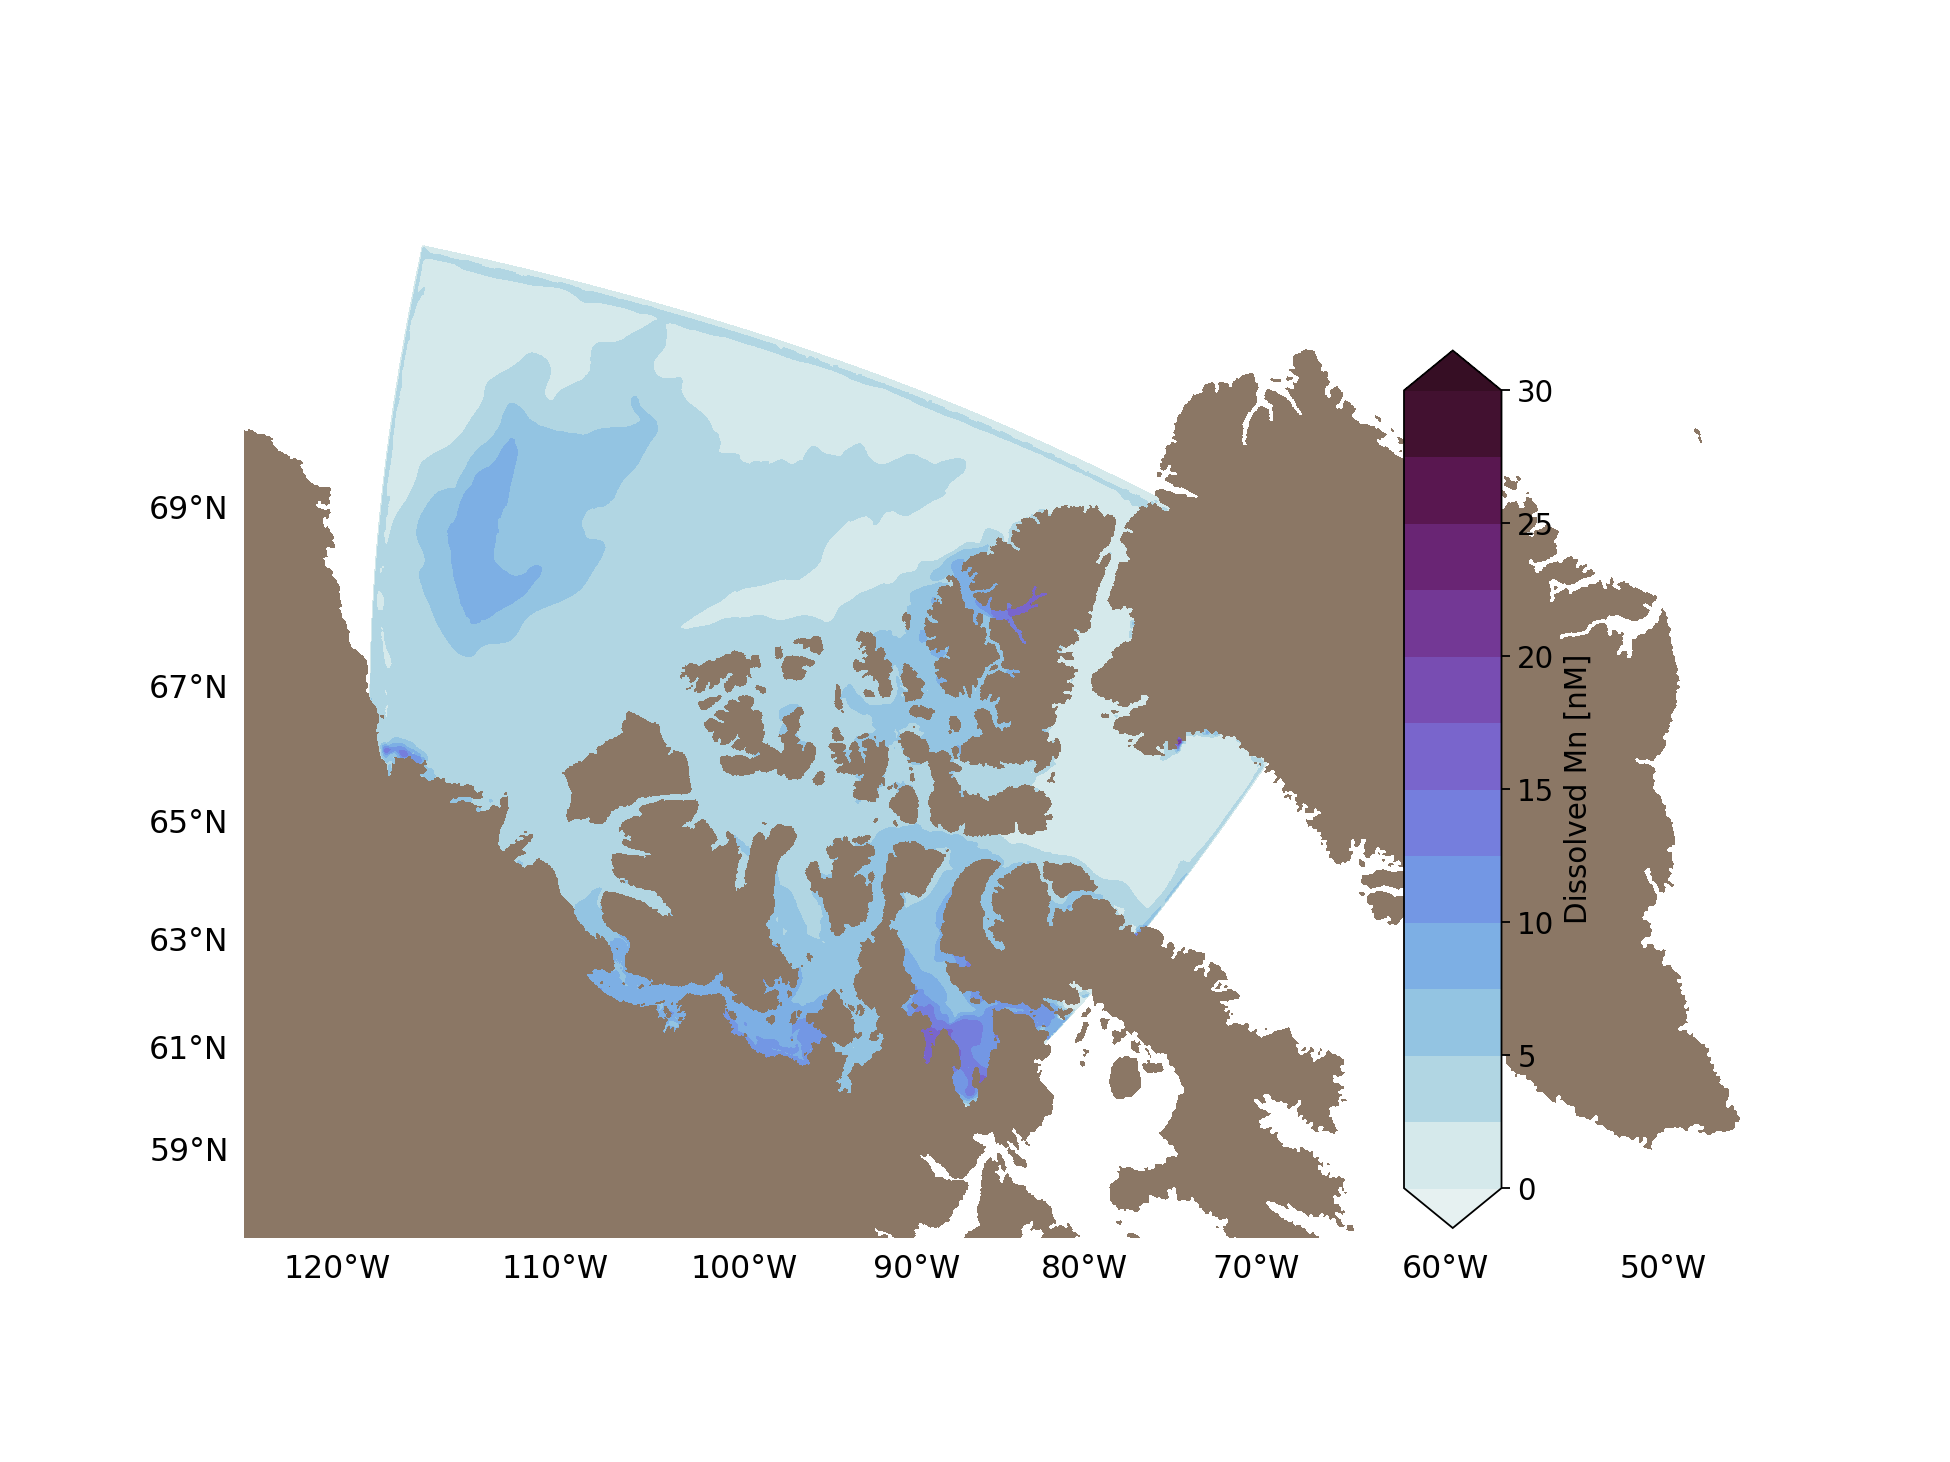

In [35]:
plot_layer(0,0,dissolmn,vmin=0,vmax=30)

<IPython.core.display.Javascript object>


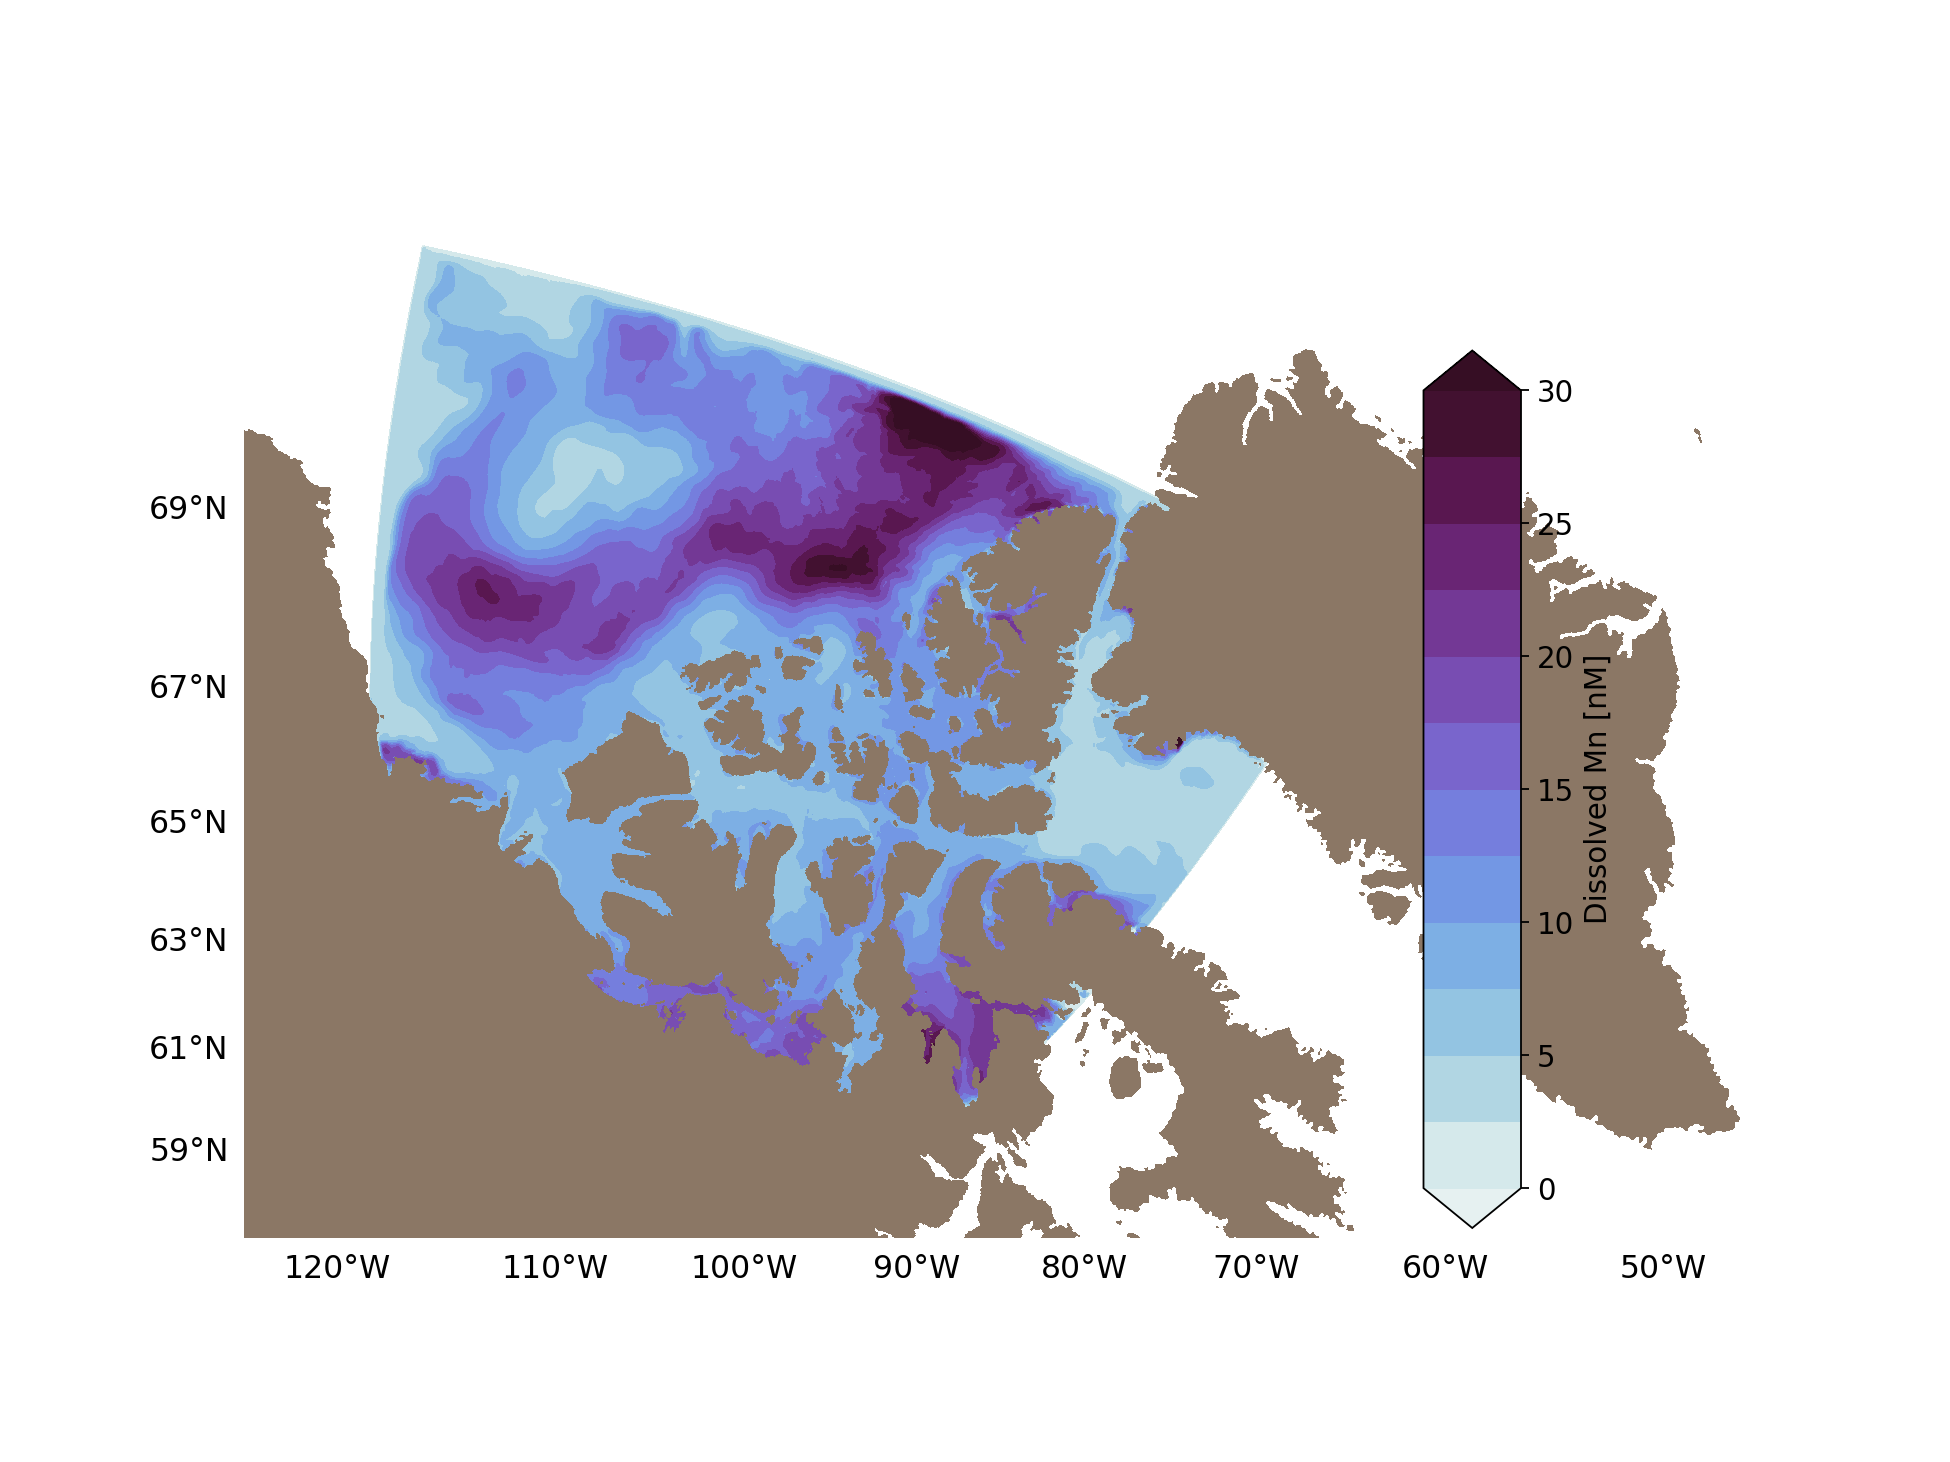

In [52]:
plot_layer(6, 0, dissolmn, vmin=0, vmax=30, savefig=True)

<IPython.core.display.Javascript object>


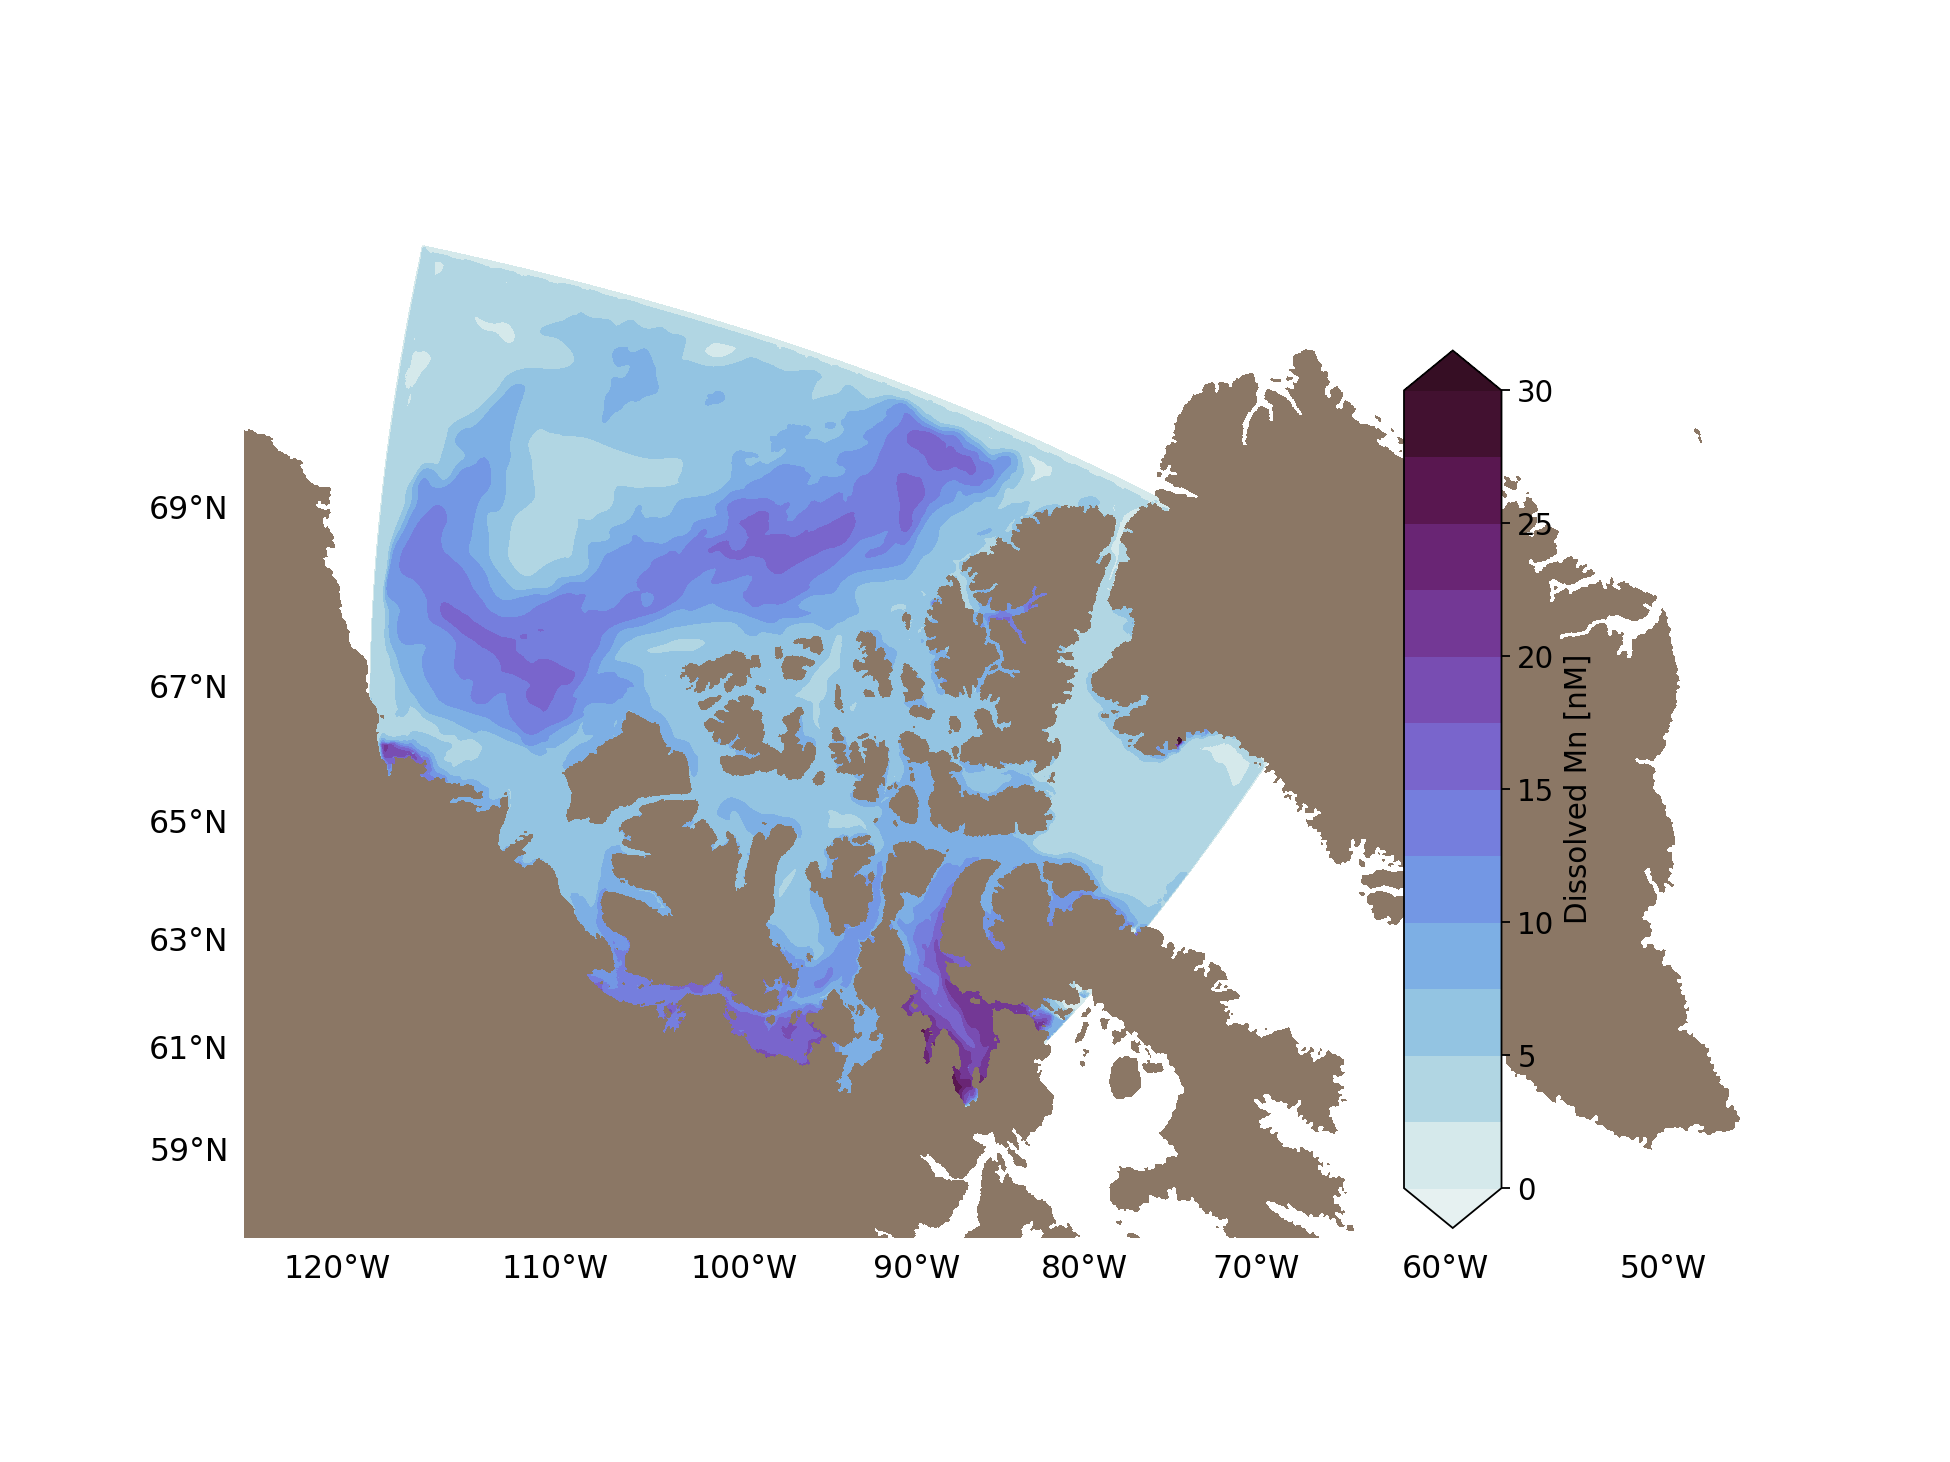

In [27]:
plot_layer(8,0,dissolmn,vmin=0,vmax=30)

<IPython.core.display.Javascript object>


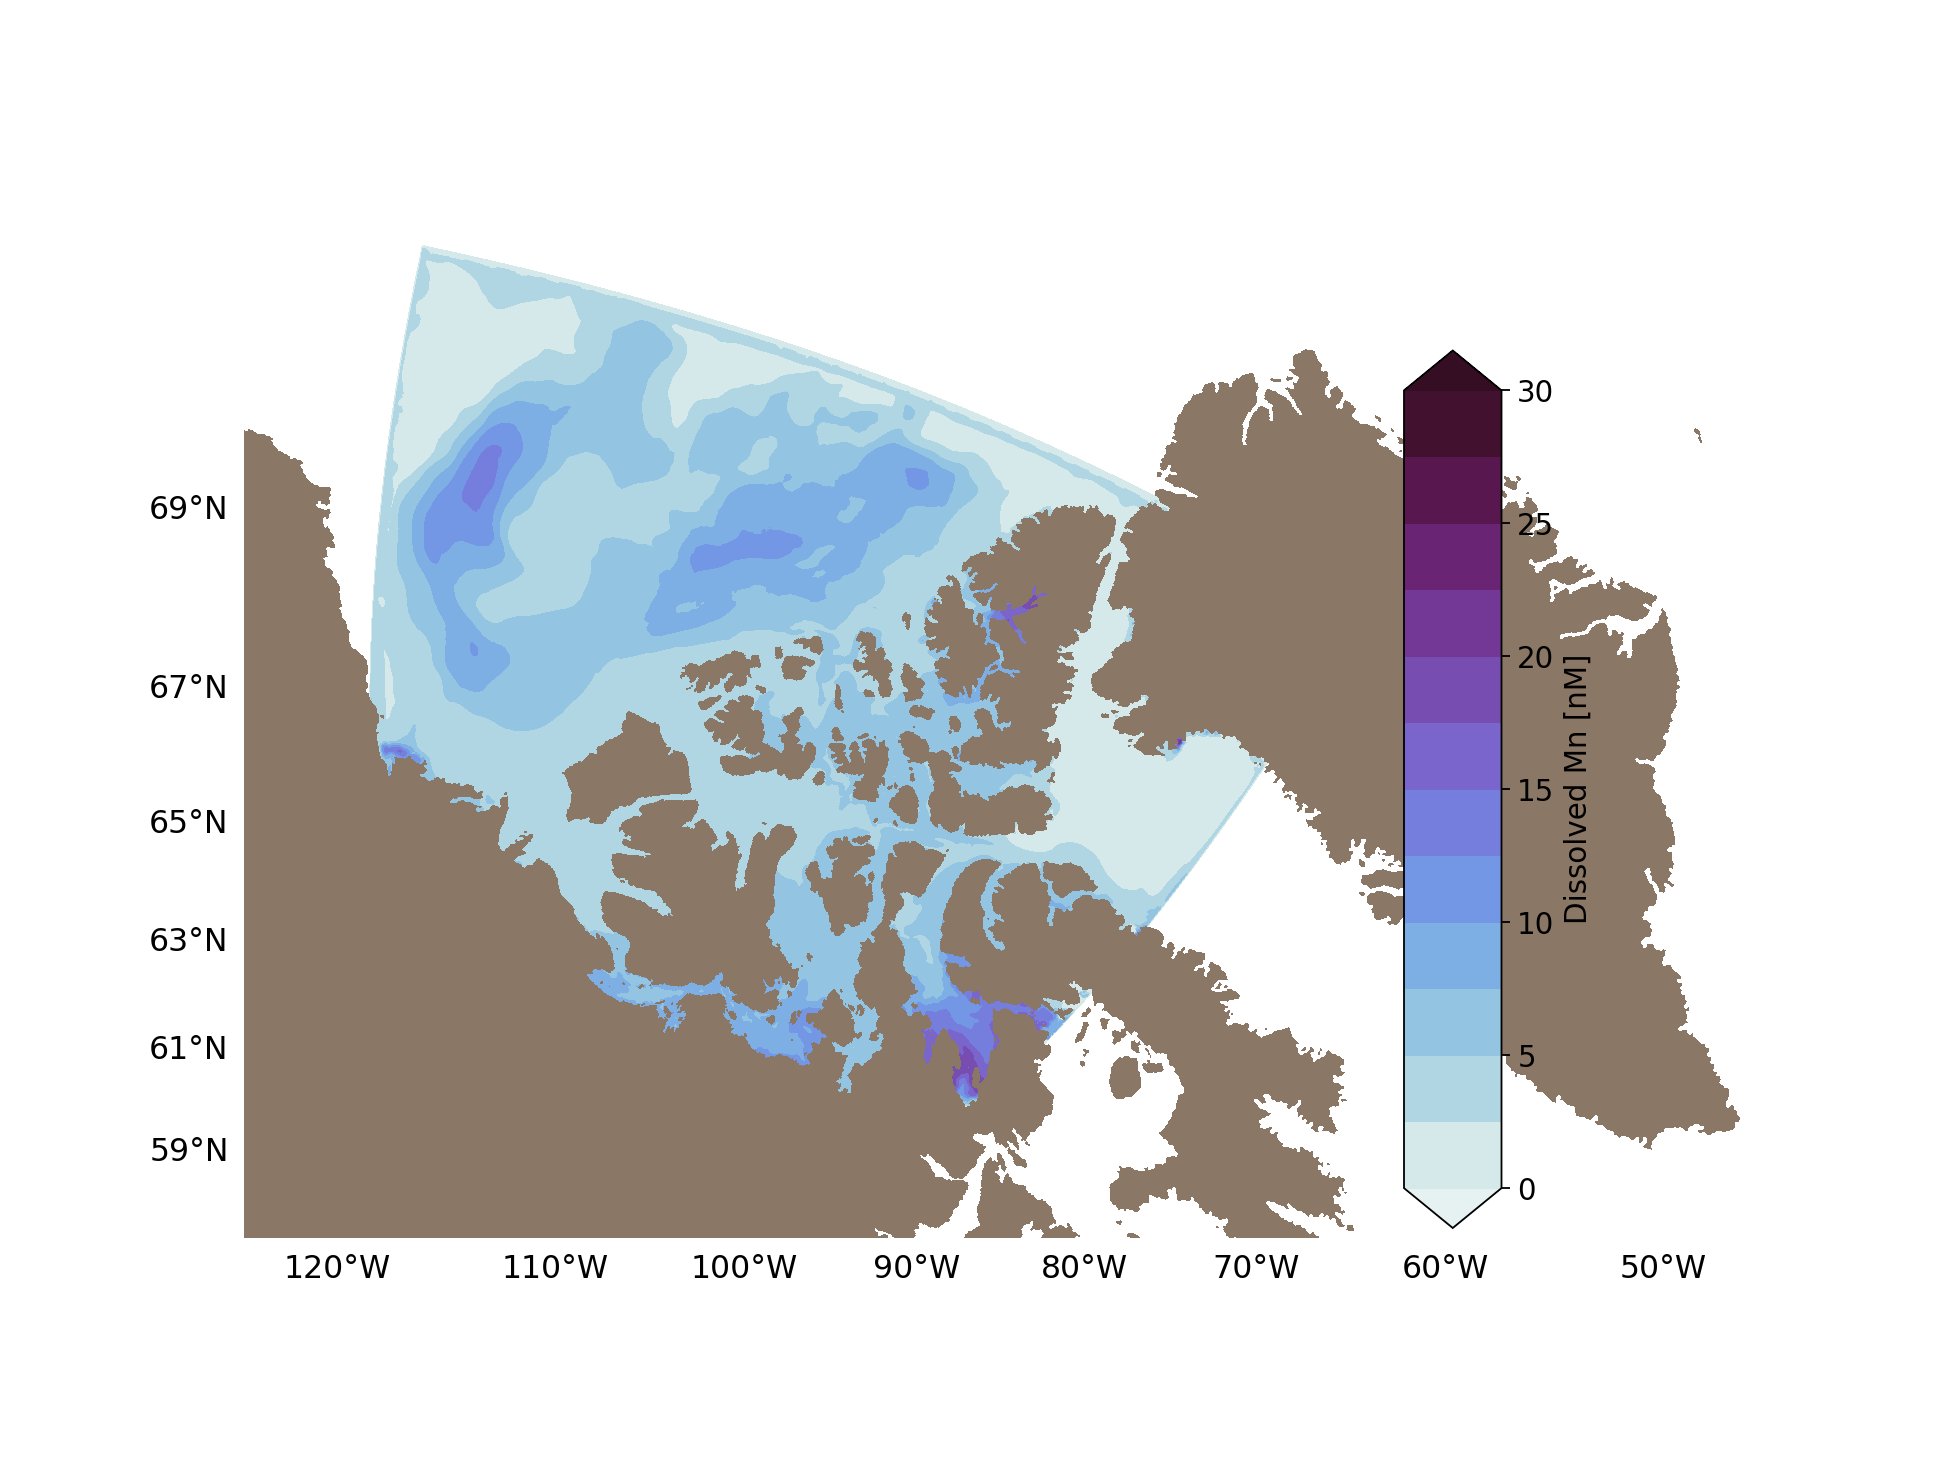

In [25]:
plot_layer(11,0,dissolmn,vmin=0,vmax=30)

#### Look at component contributions to see whether it could be due to sea ice sediment release for example

In [17]:
dmn_riv, dmn_sed, dmn_sedice, dmn_atm, dmn_ice, dmn_red, dmn_oxi = load_results(results_folder)

In [18]:
print('Maximum riverine input (nmol/L):        ', np.amax(dmn_riv))
print('Maximum sediment input (nmol/L):        ', np.amax(dmn_sed))
print('Maximum sediment in ice input (nmol/L): ', np.amax(dmn_sedice))

Maximum riverine input (nmol/L):         6970.564538077983
Maximum sediment input (nmol/L):         608.6436998928996
Maximum sediment in ice input (nmol/L):  134.48435773203218


In [19]:
print('Average riverine input (nmol/L):        ', np.average(dmn_riv[dmn_riv > 0.1]))
print('Average sediment input (nmol/L):        ', np.average(dmn_sed[dmn_sed > 0.1]))
print('Average sediment in ice input (nmol/L): ', np.average(dmn_sedice[dmn_sedice > 0.1]))
print('Average reduction input (nmol/L):       ', np.average(dmn_red[dmn_red > 0.1]))

Average riverine input (nmol/L):         119.52152157704313
Average sediment input (nmol/L):         8.87584725697829
Average sediment in ice input (nmol/L):  13.465537589458705
Average reduction input (nmol/L):        2.5830746657101376


<IPython.core.display.Javascript object>


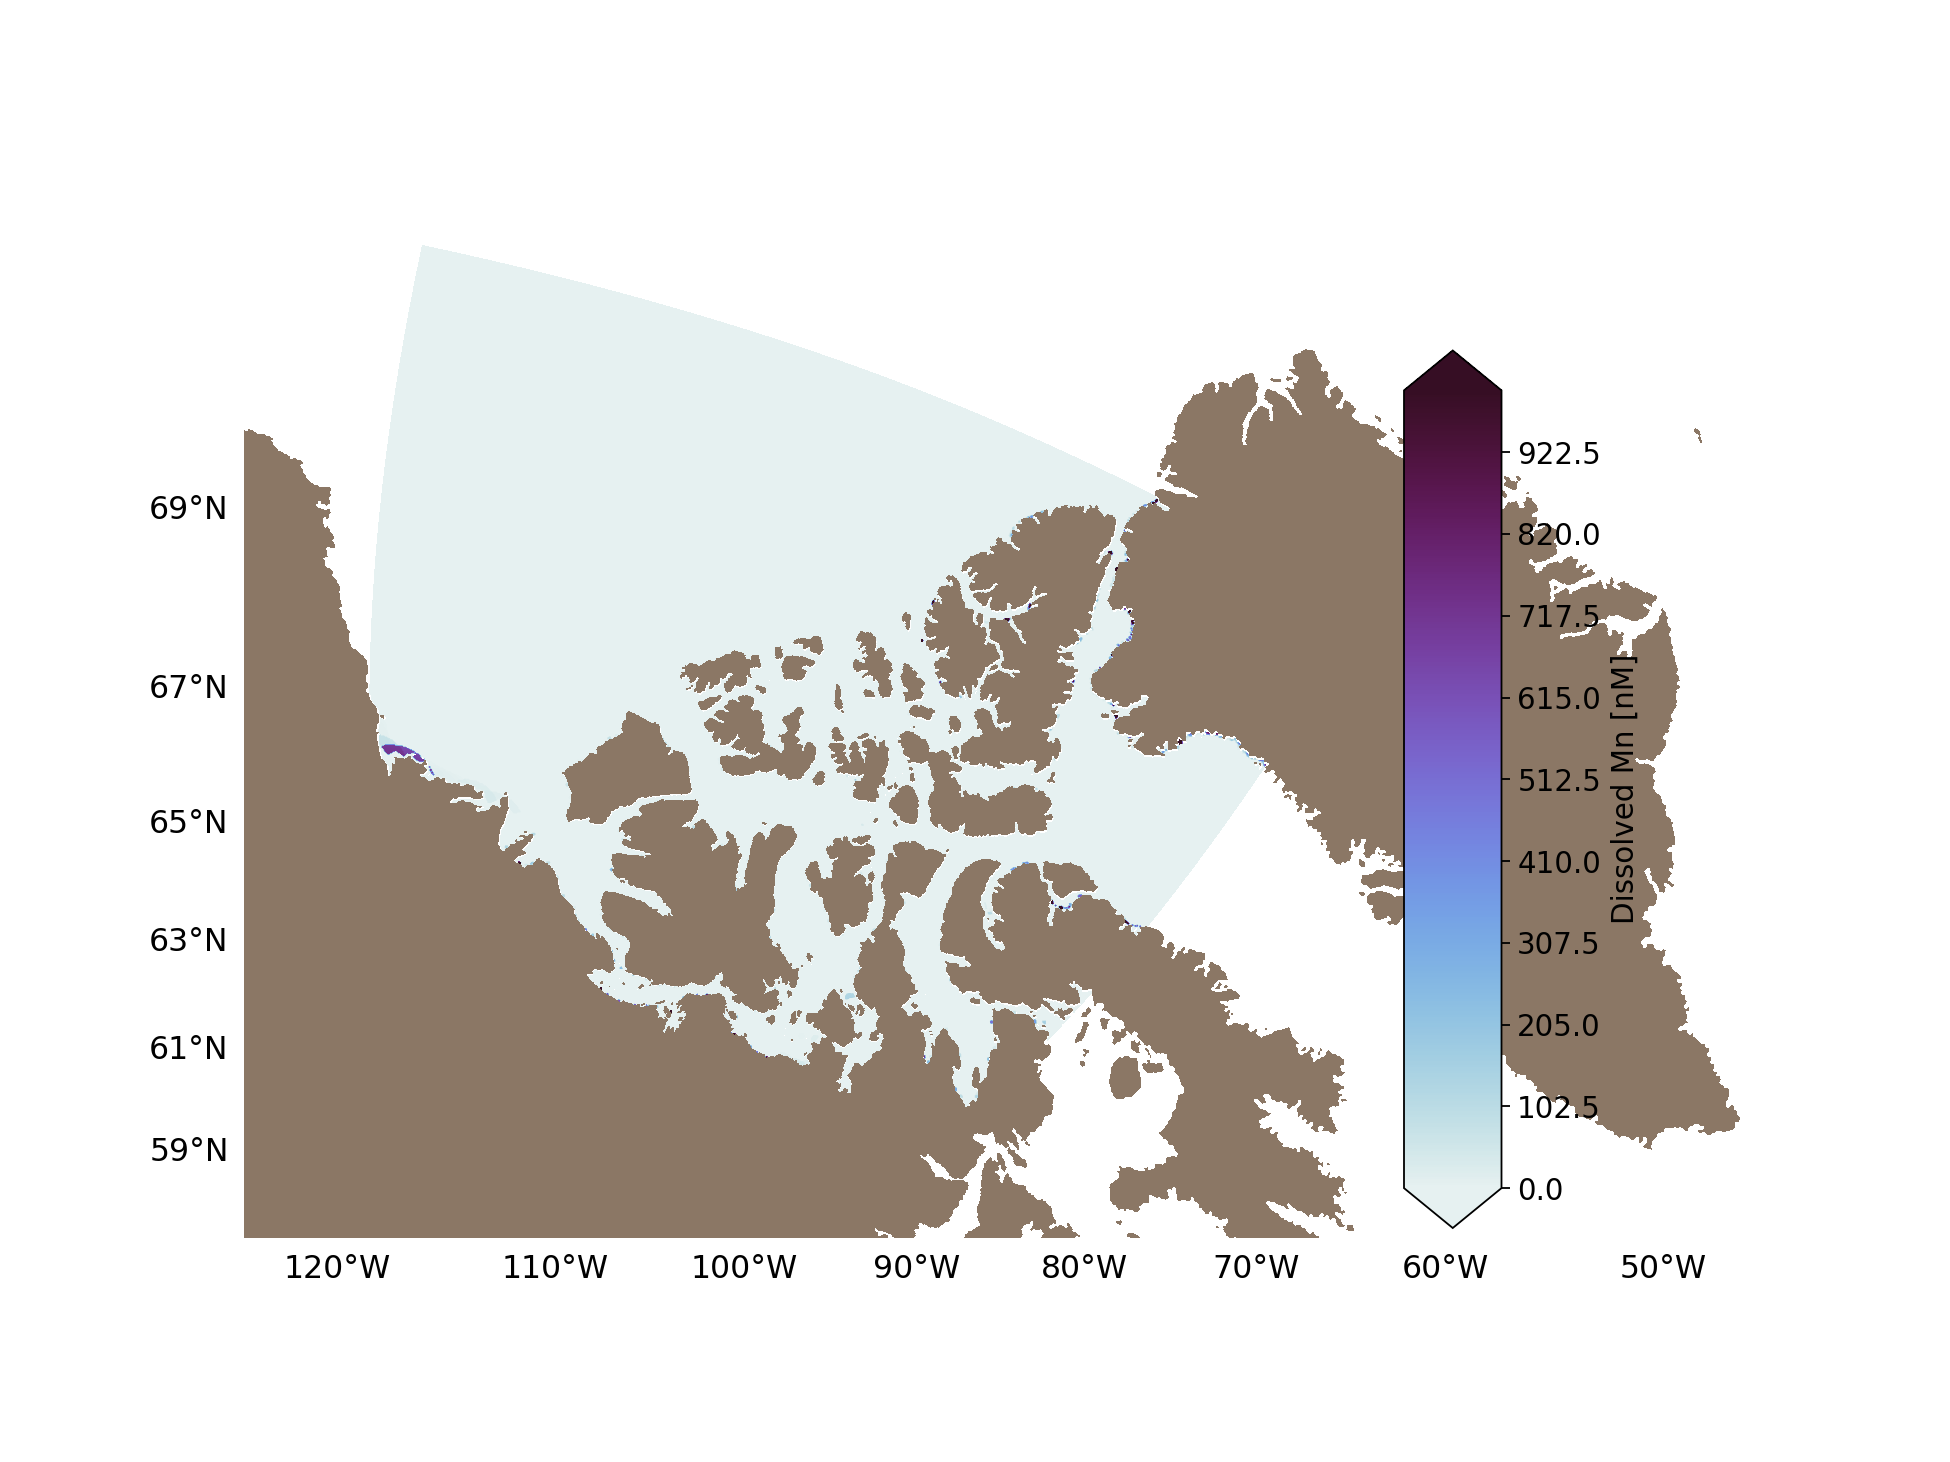

In [20]:
plot_layer(6,0,dmn_riv,vmin=0,vmax=1000)

<IPython.core.display.Javascript object>


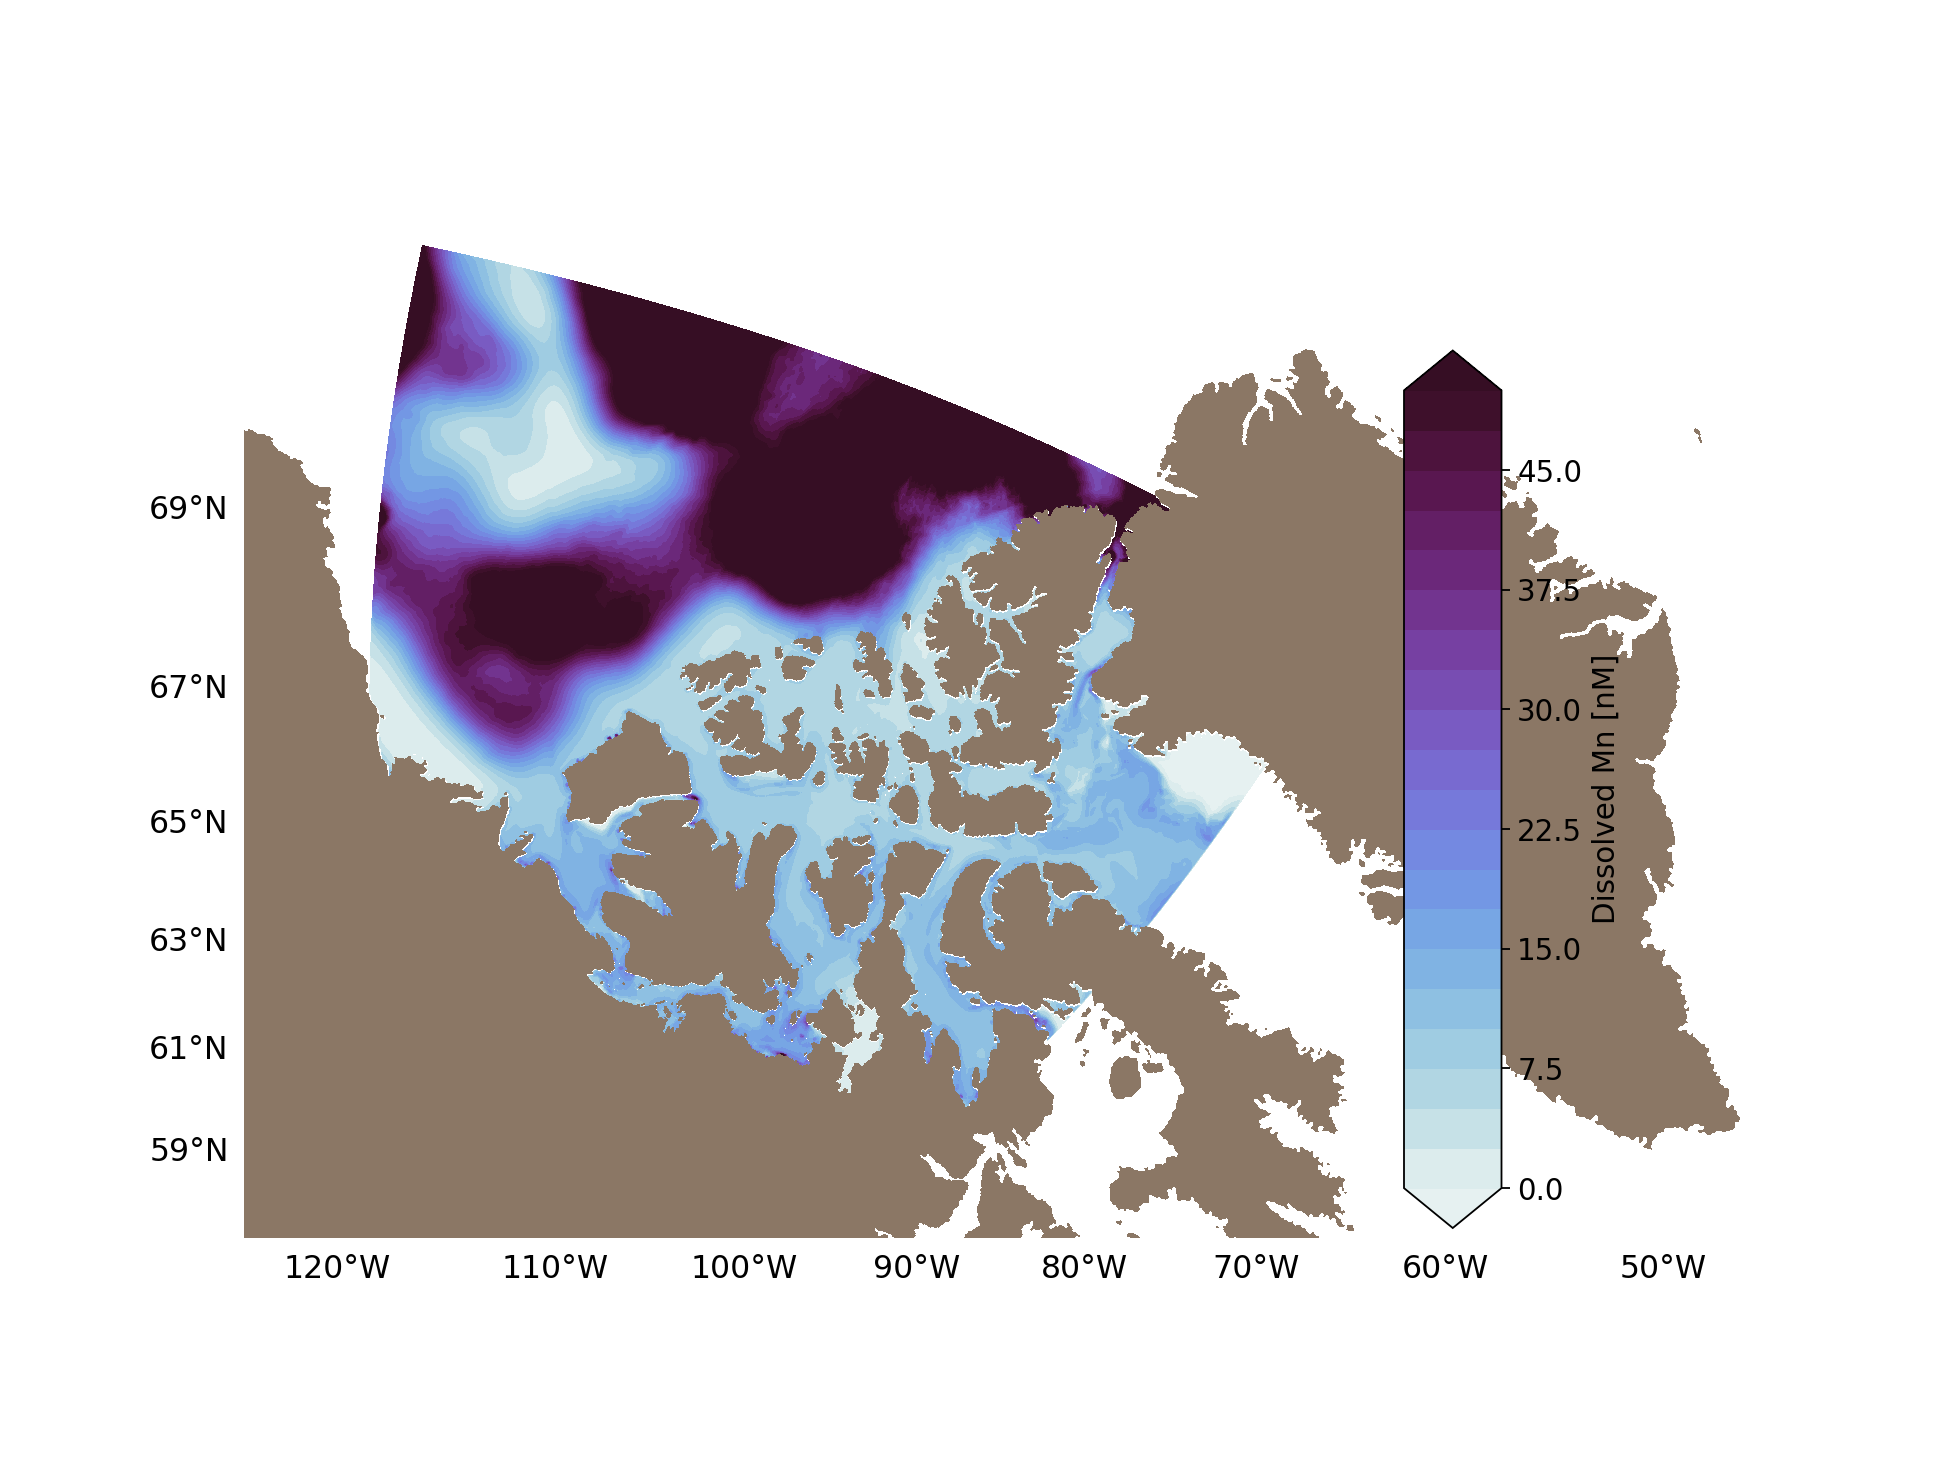

In [21]:
plot_layer(6,0,dmn_sedice,vmin=0,vmax=50)

<IPython.core.display.Javascript object>


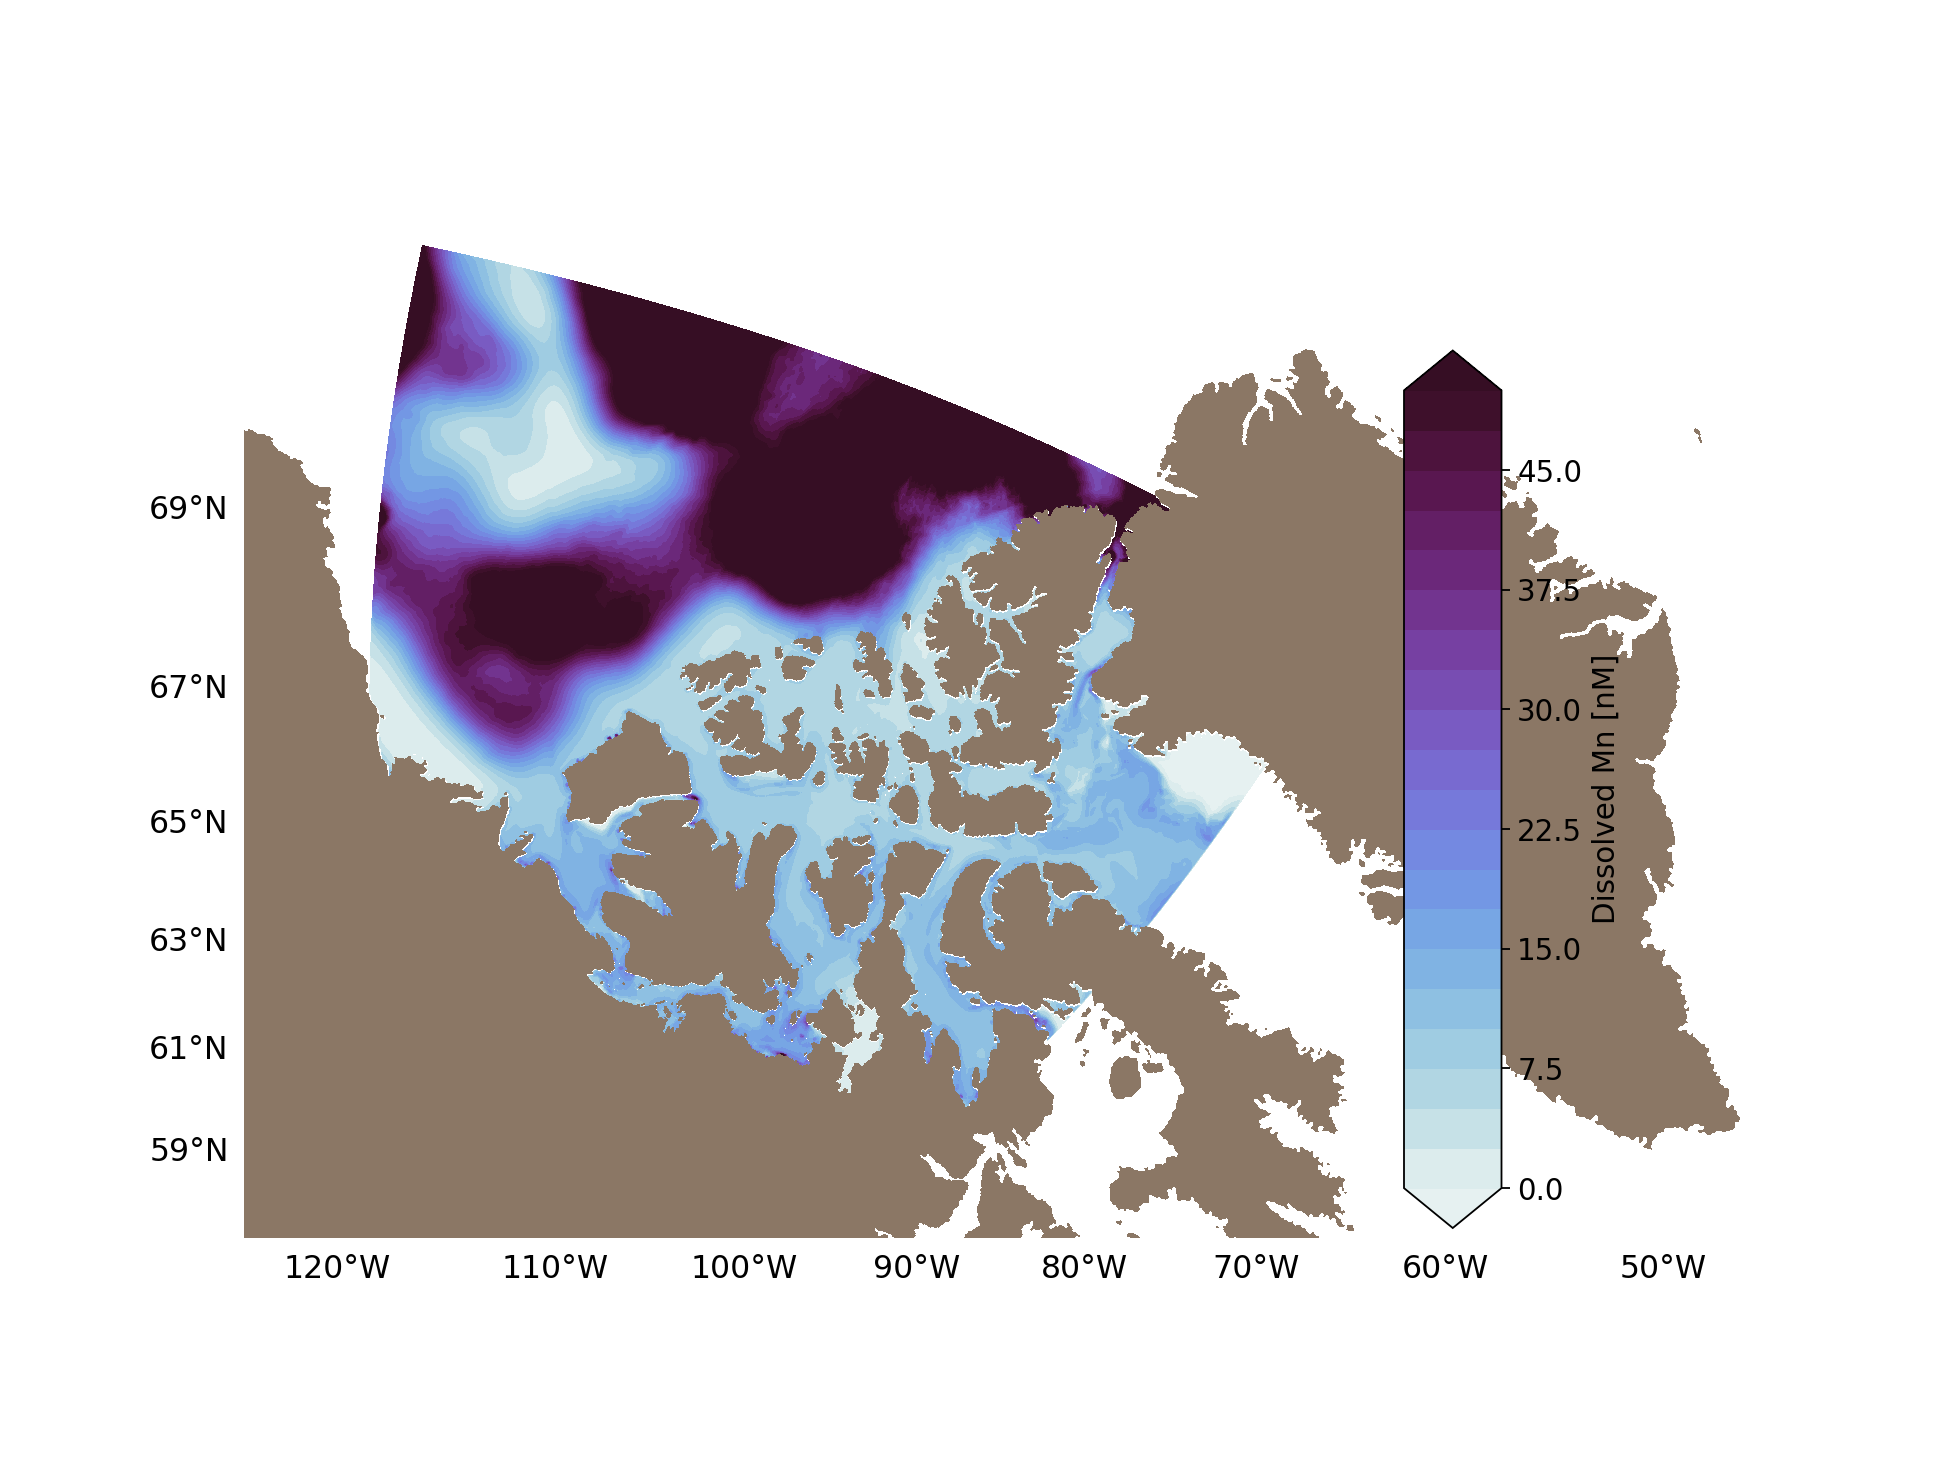

In [22]:
plot_layer(6,0,dmn_sedice,vmin=0,vmax=50)

<IPython.core.display.Javascript object>


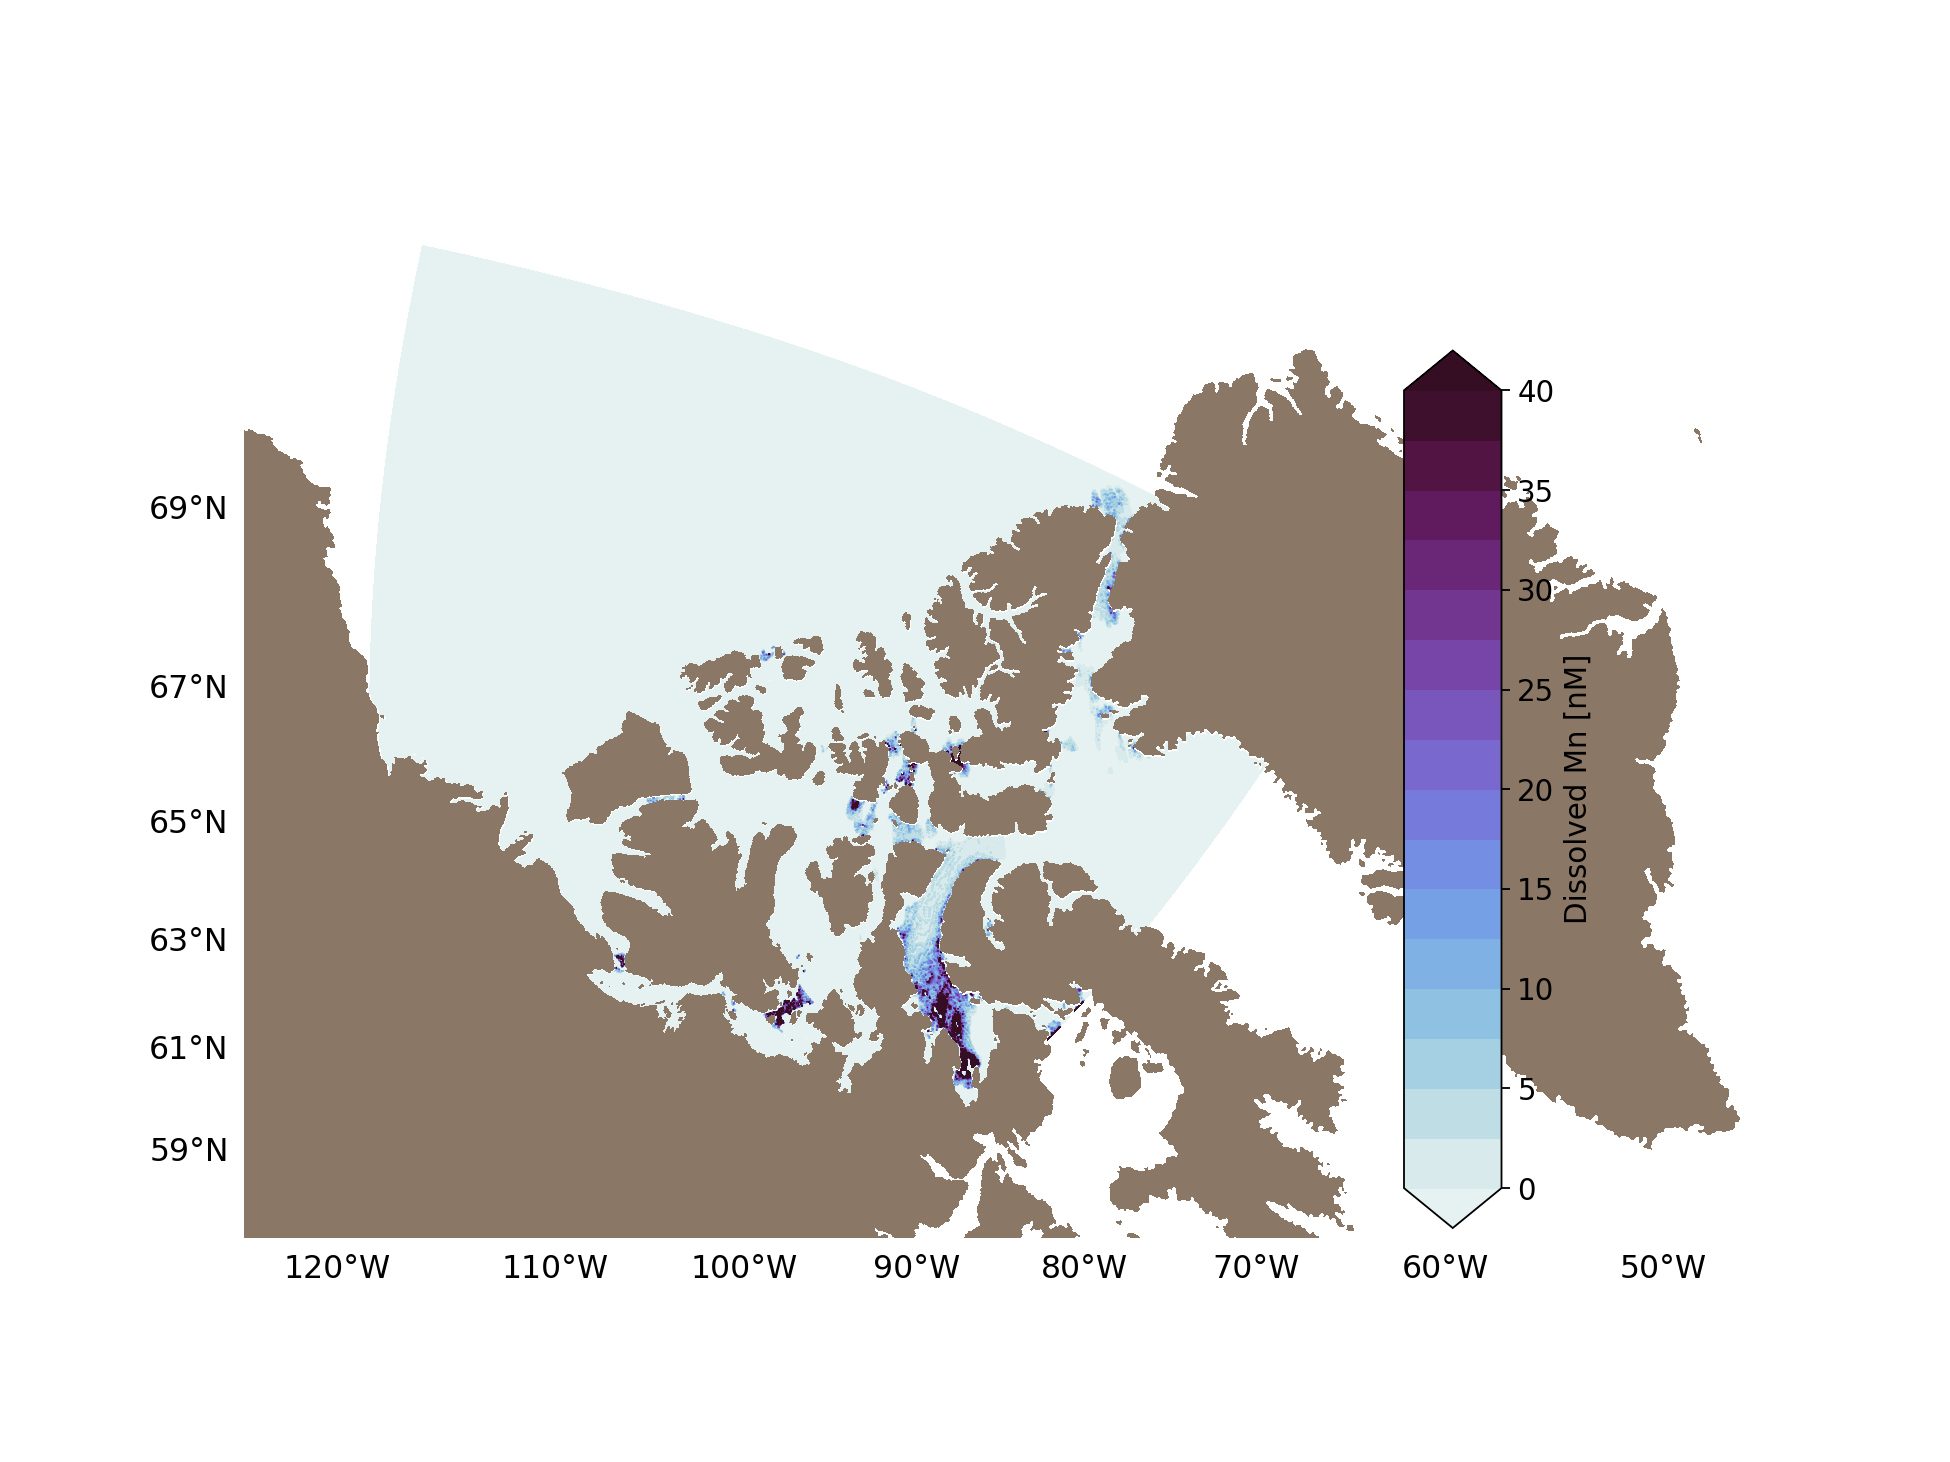

In [38]:
plot_layer(6,0,dmn_sed,vmin=0,vmax=40)

The areas with more oxidation than reduction are a result of strong river input, since I'm only putting in dissolved Mn, not particulate Mn:

<IPython.core.display.Javascript object>


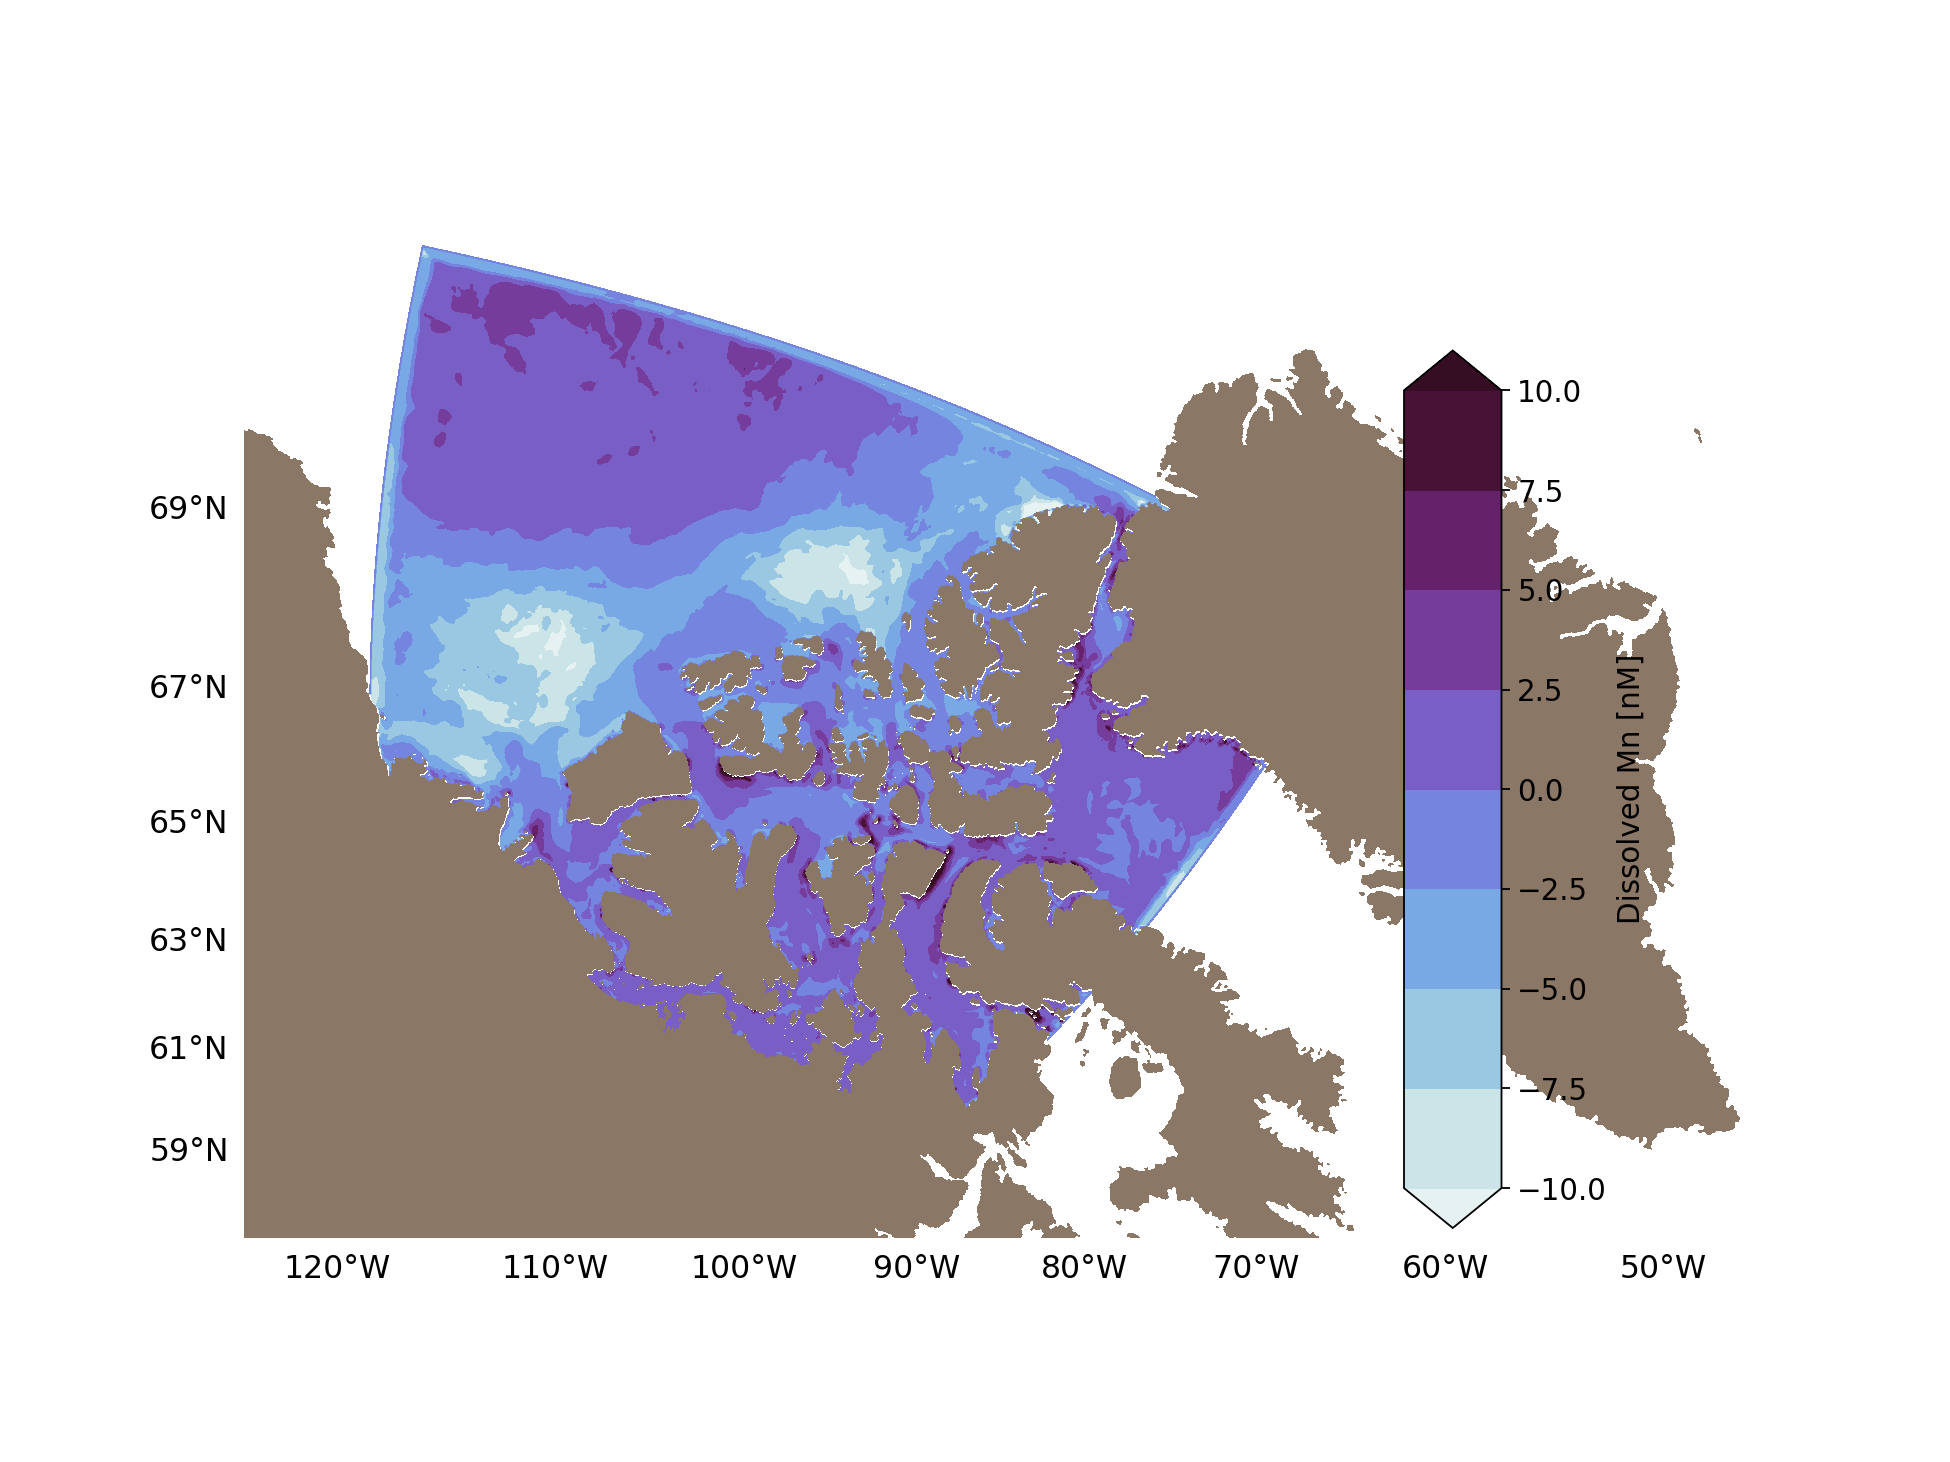

In [42]:
plot_layer(6,0,dmn_red-dmn_oxi,vmin=-10,vmax=10)

<IPython.core.display.Javascript object>


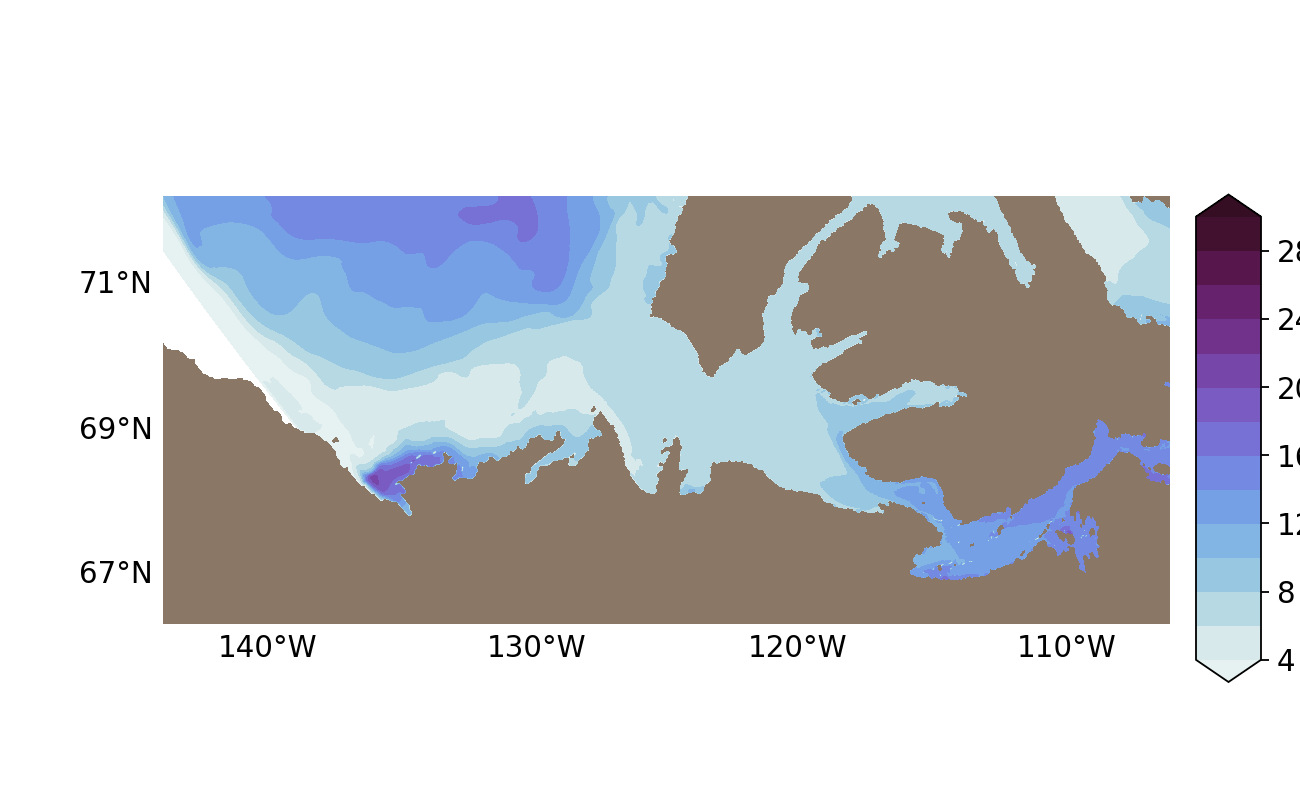

In [36]:
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/mackenzie-river.pickle','rb'))

x, y = proj1(lons, lats)
x_barrow, y_barrow = proj1([-99, -99], [73.6, 75.3])

vmin    = 4
vmax    = 30
contour = proj1.contourf(x, y, dissolmn[month,layer,:,:], np.arange(vmin,vmax+1,2),\
                             cmap=cmocean.cm.dense, vmin=vmin, vmax=vmax, extend='both')


cbar_ax = fig.add_axes([0.92, 0.16, 0.05, 0.6])
cbar    = fig.colorbar(contour, cax=cbar_ax)
cbar.set_label('Dissolved Mn [nM]', fontsize=13) 
cbar_ax.tick_params(axis='both', which='major', labelsize=13)


# fig.savefig('/ocean/brogalla/GEOTRACES/figures/R3-Mackenzie-River.png', bbox_inches='tight', dpi=300)

<IPython.core.display.Javascript object>


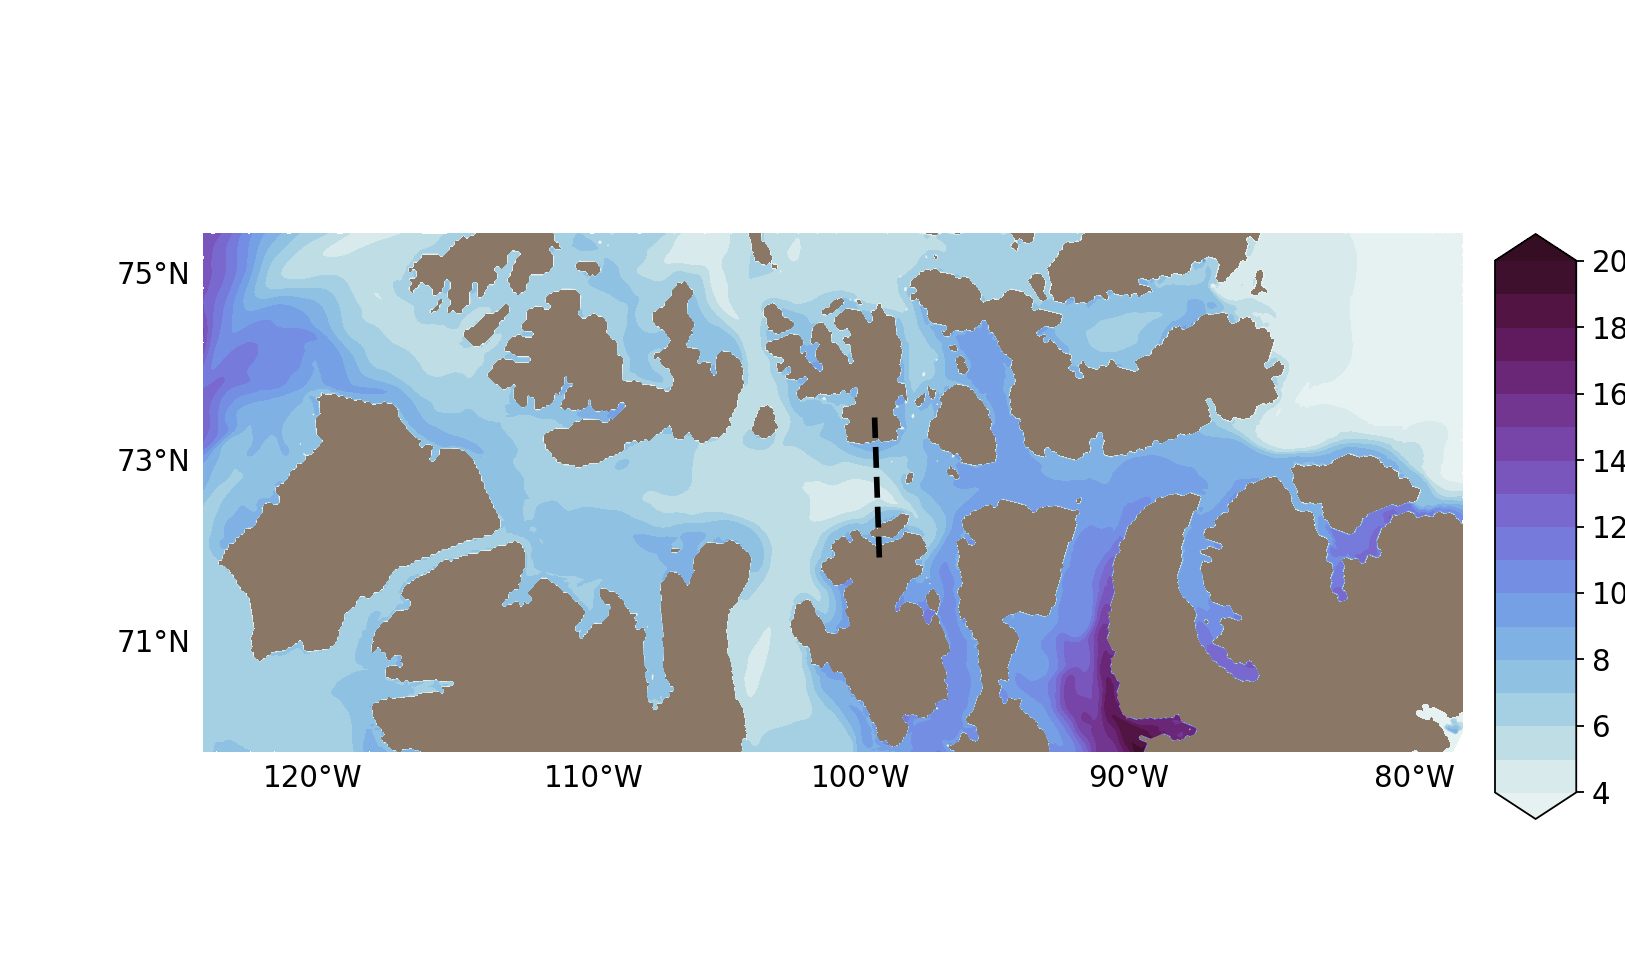

In [38]:
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/parry-channel.pickle','rb'))

x, y = proj1(lons, lats)
x_barrow, y_barrow = proj1([-99, -99], [73.6, 75.3])

vmin    = 4
vmax    = 20
contour = proj1.contourf(x, y, dissolmn[month,layer,:,:], np.arange(vmin,vmax+1,1),\
                             cmap=cmocean.cm.dense, vmin=vmin, vmax=vmax, extend='both')

vmin2 = 4
vmax2 = 20
dmn   = np.ma.masked_where((tmask[layer,:,:] < 0.1), dissolmn[month,layer,:,:]) 
# proj1.contour(x, y, dissolmn[month,layer,:,:], levels=np.arange(vmin2,vmax2+1,4), \
#               vmin=vmin2, vmax=vmax2, colors='#1a2b75')

# proj1.plot(x_barrow, y_barrow, '--w', linewidth=3.0)
proj1.plot(x_barrow, y_barrow, '--k', linewidth=2.5)

cbar_ax = fig.add_axes([0.92, 0.16, 0.05, 0.6])
cbar    = fig.colorbar(contour, cax=cbar_ax)
cbar.set_label('Dissolved Mn [nM]', fontsize=13) 
cbar_ax.tick_params(axis='both', which='major', labelsize=13)


# fig.savefig('/ocean/brogalla/GEOTRACES/figures/R3-Parry-Channel.png', bbox_inches='tight', dpi=300)

<IPython.core.display.Javascript object>


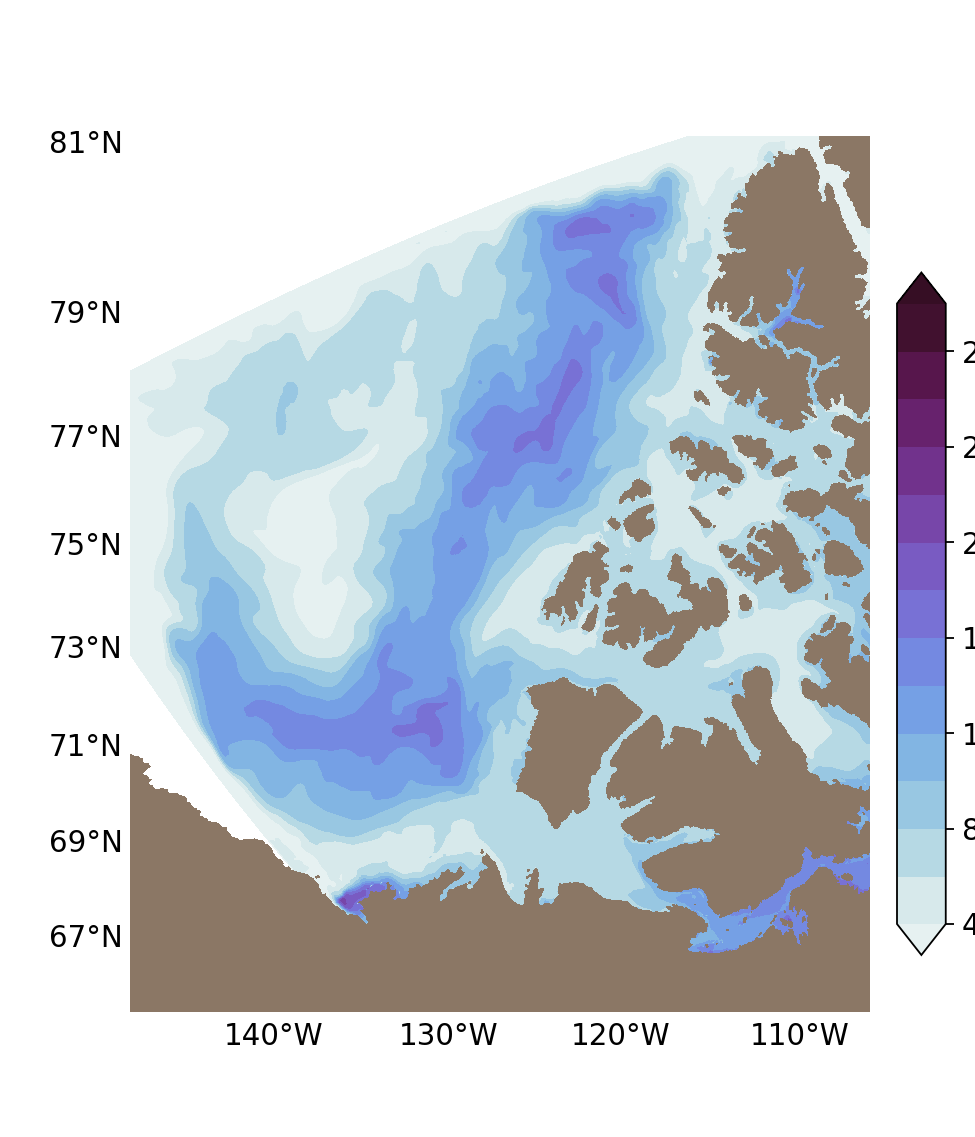

In [39]:
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/canada-basin.pickle','rb'))

x, y = proj1(lons, lats)

vmin    = 4
vmax    = 30
contour = proj1.contourf(x, y, dissolmn[month,layer,:,:], np.arange(vmin,vmax+1,2),\
                             cmap=cmocean.cm.dense, vmin=vmin, vmax=vmax, extend='both')

cbar_ax = fig.add_axes([0.92, 0.16, 0.05, 0.6])
cbar    = fig.colorbar(contour, cax=cbar_ax)
cbar.set_label('Dissolved Mn [nM]', fontsize=13) 
cbar_ax.tick_params(axis='both', which='major', labelsize=13)

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/R3-Canada-Basin.png', bbox_inches='tight', dpi=300)